## 1. Data Preparation

### 1.1. Import Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge , ElasticNet , Lasso
from sklearn.ensemble import RandomForestRegressor  , AdaBoostRegressor 

- Import data, check for comlumns and variables
### 1.2. Load and Clean Data
Load the dataset, inspect its structure, and perform initial cleaning. We drop the original 'Price' column (in Toman) and use 'Price(USD)' for our analysis, renaming it to 'Price'.

In [23]:
houses = pd.read_csv("./data/housePrice.csv")
houses = houses.drop('Price', axis=1)
houses = houses.rename(columns={'Price(USD)': 'Price'})
houses.info()
houses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3474 non-null   object 
 1   Room       3474 non-null   int64  
 2   Parking    3474 non-null   bool   
 3   Warehouse  3474 non-null   bool   
 4   Elevator   3474 non-null   bool   
 5   Address    3451 non-null   object 
 6   Price      3474 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 118.9+ KB


,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,420,4,True,True,True,Zaferanieh,3080000.00
1,705,5,True,True,False,Abazar,3033333.33
2,400,5,True,True,False,Lavasan,2833333.33
3,680,5,True,True,False,Ekhtiarieh,2720000.00
4,350,4,True,True,True,Niavaran,2683333.33


- Since the Address column has some missing data in certain rows, we will drop these rows.

In [24]:
houses = houses.dropna(subset=['Address'])

- Check the header again

In [25]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3451 entries, 0 to 3473
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3451 non-null   object 
 1   Room       3451 non-null   int64  
 2   Parking    3451 non-null   bool   
 3   Warehouse  3451 non-null   bool   
 4   Elevator   3451 non-null   bool   
 5   Address    3451 non-null   object 
 6   Price      3451 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 144.9+ KB


- That said, the data is now complete. HOWEVER, we have not yet categorized the data into the two main types: Numerical and Categorical. Now, we will do that.

In [26]:
# Convert specified columns to categorical data type
houses['Room'] = houses['Room'].astype('category')
houses['Parking'] = houses['Parking'].astype('category')
houses['Warehouse'] = houses['Warehouse'].astype('category')
houses['Elevator'] = houses['Elevator'].astype('category')

# Fix 'Area' datatype
houses['Area'] = pd.to_numeric(houses['Area'], errors='coerce')
houses = houses.dropna(subset=['Area'])
# Verify the changes
print("Data types after conversion:")
print(houses.dtypes)
houses.info()

Data types after conversion:
Area          float64
Room         category
Parking      category
Warehouse    category
Elevator     category
Address        object
Price         float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3449 entries, 0 to 3473
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Area       3449 non-null   float64 
 1   Room       3449 non-null   category
 2   Parking    3449 non-null   category
 3   Warehouse  3449 non-null   category
 4   Elevator   3449 non-null   category
 5   Address    3449 non-null   object  
 6   Price      3449 non-null   float64 
dtypes: category(4), float64(2), object(1)
memory usage: 121.7+ KB


### 1.3. Outlier Removal
To prevent extreme values from skewing the analysis, we remove the top and bottom 1% of properties based on price.

In [27]:
# Calculate 1st and 99th percentiles
lower_percentile = houses['Price'].quantile(0.1)
upper_percentile = houses['Price'].quantile(0.97) # !!!

print(f"1st percentile (1% lowest): ${lower_percentile:.2f}")
print(f"99th percentile (1% highest): ${upper_percentile:.2f}")

# Remove outliers
houses_before = len(houses)
houses = houses[(houses['Price'] >= lower_percentile) & (houses['Price'] <= upper_percentile)]
houses_after = len(houses)

print(f"\nDataset size before removing outliers: {houses_before}")
print(f"Dataset size after removing outliers: {houses_after}")
print(f"Removed {houses_before - houses_after} outliers ({((houses_before - houses_after) / houses_before * 100):.1f}%)")

1st percentile (1% lowest): $23000.00
99th percentile (1% highest): $805600.00

Dataset size before removing outliers: 3449
Dataset size after removing outliers: 3002
Removed 447 outliers (13.0%)


## 2. Feature Engineering & Data Preprocessing

- Convert the True/False values in the amenities to 0/1.

In [28]:
# Convert True/False values to 1/0 for utility features
houses['Parking'] = houses['Parking'].astype(int)
houses['Warehouse'] = houses['Warehouse'].astype(int)
houses['Elevator'] = houses['Elevator'].astype(int)

    # Display the updated dataframe
houses.tail()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
3122,105.0,2,1,1,1,Pardis,23000.0
3123,85.0,2,1,1,1,Pardis,23000.0
3124,90.0,2,1,1,1,Northern Chitgar,23000.0
3125,90.0,2,1,1,1,Northern Chitgar,23000.0
3126,90.0,2,1,1,1,Golestan,23000.0


In [29]:
# Create categorical features using get_dummies for Address, Area_Group, and Price_Group
categorical_features = pd.get_dummies(houses[["Address"]])
houses = houses.merge(categorical_features, left_index=True, right_index=True)
houses.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Address_Abazar,Address_Abbasabad,Address_Absard,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
104,200.0,3,1,1,1,Zaferanieh,800000.0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
105,320.0,4,1,1,1,Saadat Abad,800000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
106,300.0,3,1,1,0,Golestan,800000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
107,235.0,3,1,1,1,Gheitarieh,800000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108,235.0,3,1,1,1,Gheitarieh,800000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
prepared_dataset = houses.drop(["Address"], axis=1)
prepared_dataset.head()

,Area,Room,Parking,Warehouse,Elevator,Price,Address_Abazar,Address_Abbasabad,Address_Absard,Address_Abuzar,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
104,200.0,3,1,1,1,800000.0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
105,320.0,4,1,1,1,800000.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
106,300.0,3,1,1,0,800000.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
107,235.0,3,1,1,1,800000.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108,235.0,3,1,1,1,800000.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


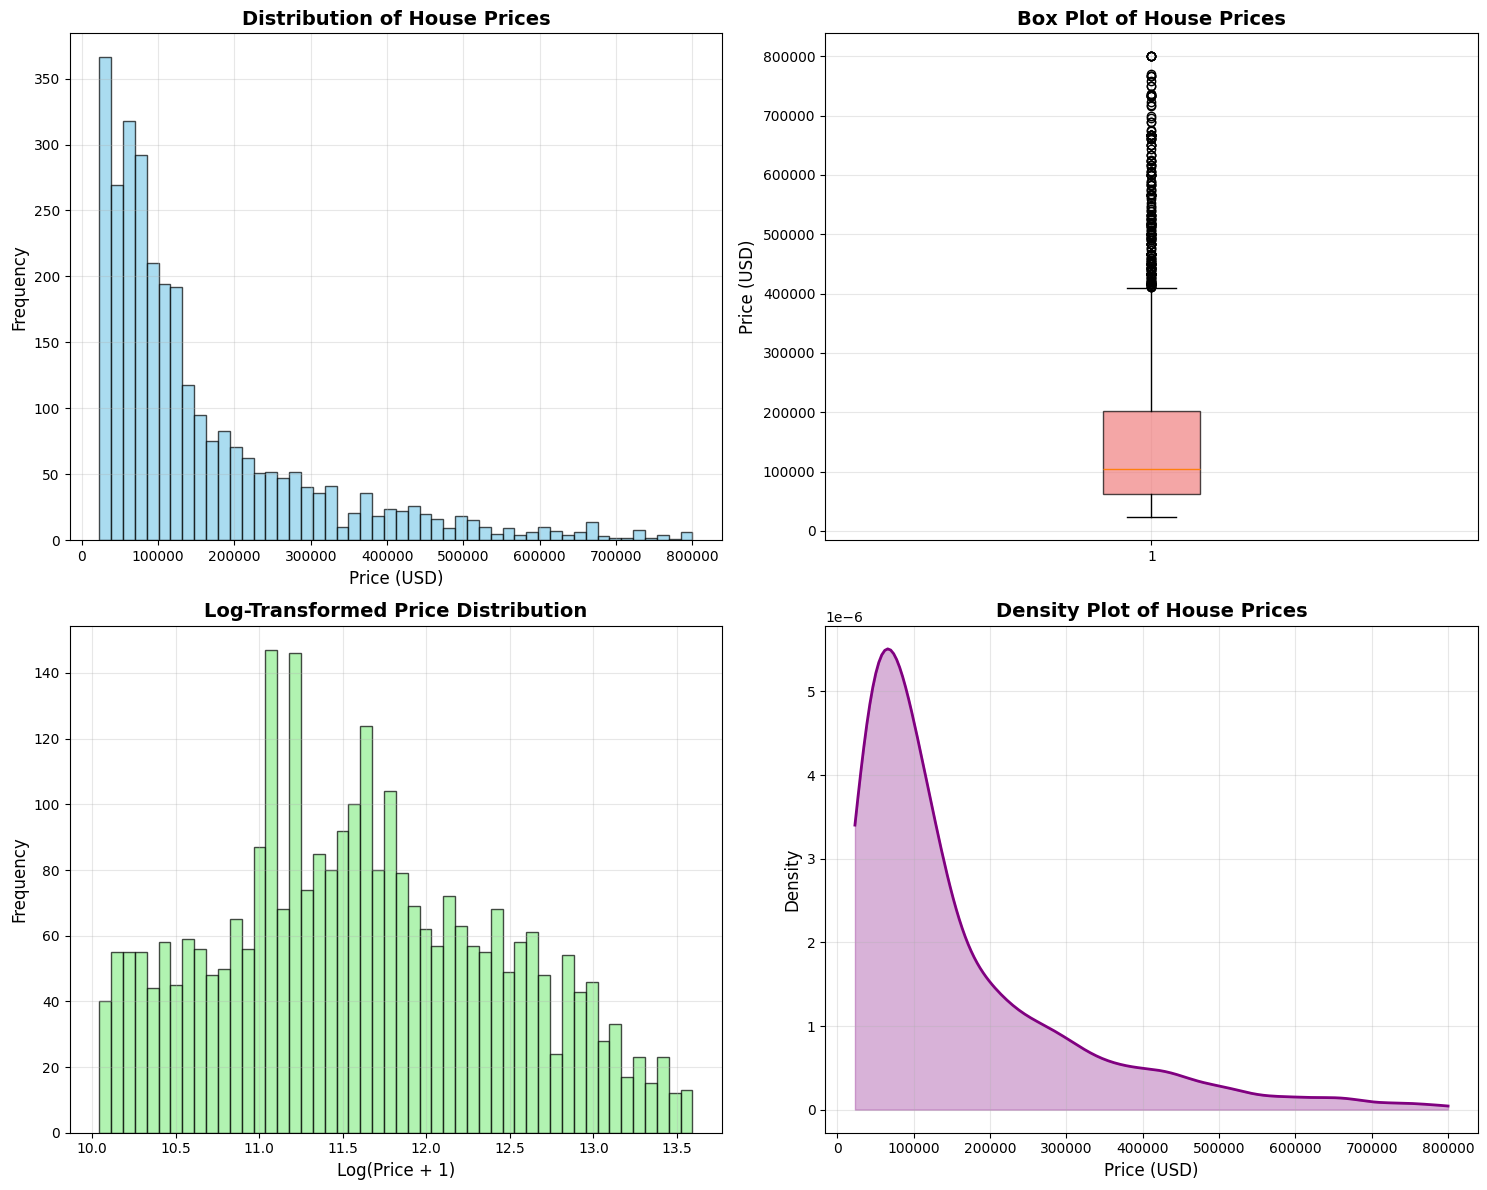

PRICE DISTRIBUTION STATISTICS
Count: 3,002
Mean: $156,549.17
Median: $105,000.00
Standard Deviation: $144,232.70
Minimum: $23,000.00
Maximum: $800,000.00
25th Percentile: $61,666.67
75th Percentile: $201,250.00
Skewness: 1.830
Kurtosis: 3.359

PRICE RANGE ANALYSIS
Budget ($0-$50K): 546 properties (18.2%)
Mid-range ($50K-$100K): 875 properties (29.1%)
Premium ($100K-$200K): 801 properties (26.7%)
Luxury ($200K-$500K): 654 properties (21.8%)
Ultra-luxury ($500K+): 126 properties (4.2%)


In [31]:
from scipy.stats import gaussian_kde

# Create visualizations for the price distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram of price distribution
axes[0, 0].hist(prepared_dataset['Price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of House Prices', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price (USD)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot to show outliers and quartiles
axes[0, 1].boxplot(prepared_dataset['Price'], vert=True, patch_artist=True, 
                   boxprops=dict(facecolor='lightcoral', alpha=0.7))
axes[0, 1].set_title('Box Plot of House Prices', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Price (USD)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Log-transformed price distribution
log_prices = np.log1p(prepared_dataset['Price'])  # log1p to handle zeros if any
axes[1, 0].hist(log_prices, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Log-Transformed Price Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Log(Price + 1)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# 4. Density plot (KDE)
density = gaussian_kde(prepared_dataset['Price'])
xs = np.linspace(prepared_dataset['Price'].min(), prepared_dataset['Price'].max(), 200)
axes[1, 1].plot(xs, density(xs), color='purple', linewidth=2)
axes[1, 1].fill_between(xs, density(xs), alpha=0.3, color='purple')
axes[1, 1].set_title('Density Plot of House Prices', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Price (USD)', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("PRICE DISTRIBUTION STATISTICS")
print("=" * 50)
print(f"Count: {prepared_dataset['Price'].count():,}")
print(f"Mean: ${prepared_dataset['Price'].mean():,.2f}")
print(f"Median: ${prepared_dataset['Price'].median():,.2f}")
print(f"Standard Deviation: ${prepared_dataset['Price'].std():,.2f}")
print(f"Minimum: ${prepared_dataset['Price'].min():,.2f}")
print(f"Maximum: ${prepared_dataset['Price'].max():,.2f}")
print(f"25th Percentile: ${prepared_dataset['Price'].quantile(0.25):,.2f}")
print(f"75th Percentile: ${prepared_dataset['Price'].quantile(0.75):,.2f}")
print(f"Skewness: {prepared_dataset['Price'].skew():.3f}")
print(f"Kurtosis: {prepared_dataset['Price'].kurtosis():.3f}")

# Additional insights
print("\nPRICE RANGE ANALYSIS")
print("=" * 50)
price_ranges = [
    (0, 50000, "Budget ($0-$50K)"),
    (50000, 100000, "Mid-range ($50K-$100K)"),
    (100000, 200000, "Premium ($100K-$200K)"),
    (200000, 500000, "Luxury ($200K-$500K)"),
    (500000, float('inf'), "Ultra-luxury ($500K+)")
]

for min_price, max_price, label in price_ranges:
    count = len(prepared_dataset[(prepared_dataset['Price'] >= min_price) & 
                                (prepared_dataset['Price'] < max_price)])
    percentage = (count / len(prepared_dataset)) * 100
    print(f"{label}: {count:,} properties ({percentage:.1f}%)")

## 3. Model training

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Define features (X) and target (y)
X = prepared_dataset.drop(["Price"], axis=1)
y = prepared_dataset["Price"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2006)

# Initialize the MinMaxScaler to scale features to a 0-1 range
scaler = MinMaxScaler()

# Fit on training data and transform both train and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data split and scaled with MinMaxScaler. Ready for training.")

Data split and scaled with MinMaxScaler. Ready for training.


### 3.1. Feature Scaling

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

- Train shape

In [34]:
print("X Train and Test shape:")
print(f'X_train : {X_train.shape}')
print(f'X_test  : {X_test.shape}')
print("---" * 30)
print("y Train and Test shape:")
print(f'y_train : {y_train.shape}')
print(f'y_test  : {y_test.shape}')
print("---" * 30)

# Also print the feature count and sample count
print("Dataset Summary:")
print(f"Total samples: {len(X_train) + len(X_test)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/(len(X_train) + len(X_test)):.2%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/(len(X_train) + len(X_test)):.2%})")
print(f"Number of features: {X_train.shape[1]}")

X Train and Test shape:
X_train : (2401, 186)
X_test  : (601, 186)
------------------------------------------------------------------------------------------
y Train and Test shape:
y_train : (2401,)
y_test  : (601,)
------------------------------------------------------------------------------------------
Dataset Summary:
Total samples: 3002
Training samples: 2401 (79.98%)
Testing samples: 601 (20.02%)
Number of features: 186


- Save the index and performance of each type of model on the dataset.

In [35]:
Model_Name  = []
Train_Score = []
Test_Score  = []
MSE_Score   = []
RMSE_Score  = []
Time_Score  = []

In [36]:
def model_prediction(model):
    
    start_time = time.time()
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    y_prediction = [i if i>0 else 0 for i in y_prediction]
    TestScore = r2_score(y_test, y_prediction)
    TrainScore = model.score(X_train, y_train)
    # TestScore = model.score(X_test, y_test) 
    MSEscore = mean_squared_error(y_test, y_prediction)
    RMSEscore = np.sqrt(MSEscore)
    end_time = time.time()
    Timescore = end_time - start_time
    
    Name = str(model).split('(')[0]
    Model_Name.append(Name)
    Train_Score.append(TrainScore)
    Test_Score.append(TestScore)
    MSE_Score.append(MSEscore)
    RMSE_Score.append(RMSEscore)
    Time_Score.append(Timescore)

    print(f'Model: {Name}')
    print('=' * 50)
    print(f'Training R² Score: {TrainScore:.4f} ({TrainScore*100:.2f}%)')
    print(f'Testing R² Score:  {TestScore:.4f} ({TestScore*100:.2f}%)')
    print('=' * 50)
    print(f'Mean Squared Error:  ${MSEscore:,.0f}')
    print(f'Root Mean Squared Error: ${RMSEscore:,.0f}')
    print('=' * 50)
    print(f'Training Time: {Timescore:.3f} seconds')
    print('\n')


1.  Regression Model

In [37]:
model_prediction(ElasticNet())

Model: ElasticNet
Training R² Score: 0.7361 (73.61%)
Testing R² Score:  0.7131 (71.31%)
Mean Squared Error:  $5,648,567,285
Root Mean Squared Error: $75,157
Training Time: 0.009 seconds




In [38]:
model_prediction(Lasso())

Model: Lasso
Training R² Score: 0.7918 (79.18%)
Testing R² Score:  0.7352 (73.52%)
Mean Squared Error:  $5,214,028,972
Root Mean Squared Error: $72,208
Training Time: 0.286 seconds




In [39]:
model_prediction(Ridge())

Model: Ridge
Training R² Score: 0.7918 (79.18%)
Testing R² Score:  0.7340 (73.40%)
Mean Squared Error:  $5,236,667,368
Root Mean Squared Error: $72,365
Training Time: 0.036 seconds




In [40]:

model_prediction(KNeighborsRegressor())
model_prediction(DecisionTreeRegressor())
model_prediction(RandomForestRegressor())
model_prediction(AdaBoostRegressor())

Model: KNeighborsRegressor
Training R² Score: 0.8733 (87.33%)
Testing R² Score:  0.7367 (73.67%)
Mean Squared Error:  $5,184,667,761
Root Mean Squared Error: $72,005
Training Time: 0.106 seconds


Model: DecisionTreeRegressor
Training R² Score: 0.9836 (98.36%)
Testing R² Score:  0.5868 (58.68%)
Mean Squared Error:  $8,136,357,700
Root Mean Squared Error: $90,202
Training Time: 0.023 seconds


Model: RandomForestRegressor
Training R² Score: 0.9636 (96.36%)
Testing R² Score:  0.7441 (74.41%)
Mean Squared Error:  $5,038,674,340
Root Mean Squared Error: $70,984
Training Time: 1.389 seconds


Model: AdaBoostRegressor
Training R² Score: 0.6569 (65.69%)
Testing R² Score:  0.5718 (57.18%)
Mean Squared Error:  $8,431,322,990
Root Mean Squared Error: $91,822
Training Time: 0.091 seconds




In [41]:
from sklearn.model_selection import cross_val_score
import warnings

# Perform cross-validation for all models
warnings.filterwarnings('ignore')

# Define models to test
models = [
    ElasticNet(),
    Lasso(),
    Ridge(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]

# Store cross-validation results
cv_results = {
    'Model': [],
    'Mean R² Score': [],
    'Std R² Score': [],
    'Mean RMSE': [],
    'Mean Training Time (s)': []
}

print("Cross-Validation Results:")
print("=" * 80)

for model in models:
    model_name = str(model).split('(')[0]
    print(f"\nEvaluating {model_name}...")
    
    # Perform 5-fold cross-validation for R² score
    start_time = time.time()
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Perform cross-validation for RMSE
    cv_rmse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_scores = np.sqrt(-cv_rmse_scores)  # Convert to positive RMSE
    
    end_time = time.time()
    training_time = (end_time - start_time) / 5  # Average time per fold
    
    # Store results
    cv_results['Model'].append(model_name)
    cv_results['Mean R² Score'].append(cv_scores.mean())
    cv_results['Std R² Score'].append(cv_scores.std())
    cv_results['Mean RMSE'].append(cv_rmse_scores.mean())
    cv_results['Mean Training Time (s)'].append(training_time)
    
    print(f"Mean R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"Mean RMSE: ${cv_rmse_scores.mean():,.0f} (±${cv_rmse_scores.std():,.0f})")
    print(f"Average Training Time: {training_time:.3f} seconds")

# Convert to DataFrame for better visualization
cv_df = pd.DataFrame(cv_results)
cv_df['Mean R² Score'] = cv_df['Mean R² Score'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
cv_df['Mean RMSE'] = cv_df['Mean RMSE'].apply(lambda x: f"${x:,.0f}")

# Sort by R² score (convert back to float for sorting)
cv_df_sorted = cv_df.copy()
cv_df_sorted['R2_numeric'] = [float(score.split(' ')[0]) for score in cv_df['Mean R² Score']]
cv_df_sorted = cv_df_sorted.sort_values('R2_numeric', ascending=False).drop('R2_numeric', axis=1)

print("\n" + "=" * 80)
print("CROSS-VALIDATION SUMMARY (Sorted by R² Score):")
print("=" * 80)
print(cv_df_sorted.to_string(index=False))

Cross-Validation Results:

Evaluating ElasticNet...
Mean R² Score: 0.7033 (±0.0398)
Mean RMSE: $78,944 (±$7,169)
Average Training Time: 0.013 seconds

Evaluating Lasso...
Mean R² Score: 0.7100 (±0.1393)
Mean RMSE: $76,561 (±$18,543)
Average Training Time: 0.352 seconds

Evaluating Ridge...
Mean R² Score: 0.7092 (±0.1394)
Mean RMSE: $76,673 (±$18,532)
Average Training Time: 0.075 seconds

Evaluating KNeighborsRegressor...
Mean R² Score: 0.7968 (±0.0278)
Mean RMSE: $65,321 (±$6,097)
Average Training Time: 0.034 seconds

Evaluating DecisionTreeRegressor...
Mean R² Score: 0.7633 (±0.0162)
Mean RMSE: $70,890 (±$4,075)
Average Training Time: 0.038 seconds

Evaluating RandomForestRegressor...
Mean R² Score: 0.8185 (±0.0241)
Mean RMSE: $61,893 (±$5,928)
Average Training Time: 2.031 seconds

CROSS-VALIDATION SUMMARY (Sorted by R² Score):
                Model   Mean R² Score  Std R² Score Mean RMSE  Mean Training Time (s)
RandomForestRegressor 0.8185 (81.85%)      0.024095   $61,893            

In [42]:
from scipy import stats

# Perform statistical comparison between RandomForest and other models
print("Statistical Comparison: RandomForestRegressor vs Other Models")
print("=" * 70)

# Get RandomForest cross-validation scores
rf_model = RandomForestRegressor(random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

print(f"RandomForest CV Scores: {rf_cv_scores}")
print(f"RandomForest Mean R²: {rf_cv_scores.mean():.4f} (±{rf_cv_scores.std():.4f})")
print()

# Compare with other top models
comparison_models = [
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('Lasso', Lasso(random_state=42)),
    ('Ridge', Ridge(random_state=42)),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42))
]

for model_name, model in comparison_models:
    # Get CV scores for comparison model
    model_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(rf_cv_scores, model_cv_scores)
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((rf_cv_scores.var() + model_cv_scores.var()) / 2)
    cohens_d = (rf_cv_scores.mean() - model_cv_scores.mean()) / pooled_std
    
    print(f"RandomForest vs {model_name}:")
    print(f"  {model_name} Mean R²: {model_cv_scores.mean():.4f} (±{model_cv_scores.std():.4f})")
    print(f"  Difference: {rf_cv_scores.mean() - model_cv_scores.mean():.4f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Cohen's d: {cohens_d:.4f}")
    
    # Interpret results
    if p_value < 0.01:
        significance = "highly significant (p < 0.01)"
    elif p_value < 0.05:
        significance = "significant (p < 0.05)"
    else:
        significance = "not significant (p >= 0.05)"
    
    if abs(cohens_d) < 0.2:
        effect_size = "small"
    elif abs(cohens_d) < 0.5:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"  Result: RandomForest is {significance} better with {effect_size} effect size")
    print("-" * 50)

# Overall conclusion
print("\nCONCLUSION:")
print("=" * 70)
best_competitor = max(comparison_models, key=lambda x: cross_val_score(x[1], X_train, y_train, cv=5, scoring='r2').mean())
competitor_scores = cross_val_score(best_competitor[1], X_train, y_train, cv=5, scoring='r2')
final_t_stat, final_p_value = stats.ttest_rel(rf_cv_scores, competitor_scores)

if final_p_value < 0.05:
    print(f"✅ RandomForestRegressor significantly outperforms all other models")
    print(f"   Best competitor: {best_competitor[0]} (Mean R²: {competitor_scores.mean():.4f})")
    print(f"   Statistical significance: p = {final_p_value:.4f}")
else:
    print(f"❌ RandomForestRegressor does not significantly outperform all models")
    print(f"   Best competitor: {best_competitor[0]} performs similarly")

Statistical Comparison: RandomForestRegressor vs Other Models
RandomForest CV Scores: [0.79861047 0.80108096 0.79979824 0.84006425 0.85283341]
RandomForest Mean R²: 0.8185 (±0.0232)

RandomForest vs KNeighborsRegressor:
  KNeighborsRegressor Mean R²: 0.7968 (±0.0278)
  Difference: 0.0217
  T-statistic: 2.6807
  P-value: 0.0552
  Cohen's d: 0.8455
  Result: RandomForest is not significant (p >= 0.05) better with large effect size
--------------------------------------------------
RandomForest vs Lasso:
  Lasso Mean R²: 0.7100 (±0.1393)
  Difference: 0.1084
  T-statistic: 1.6765
  P-value: 0.1690
  Cohen's d: 1.0857
  Result: RandomForest is not significant (p >= 0.05) better with large effect size
--------------------------------------------------
RandomForest vs Ridge:
  Ridge Mean R²: 0.7092 (±0.1394)
  Difference: 0.1092
  T-statistic: 1.6879
  P-value: 0.1667
  Cohen's d: 1.0933
  Result: RandomForest is not significant (p >= 0.05) better with large effect size
---------------------